# Data exploration and visualisation

We'll need to import a few libraries. Then, we'll read the cleveland data into a `DataFrame`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [2]:
raw_data = pd.read_csv('data/processed_cleveland_data.csv')
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
column_a    303 non-null int64
column_b    303 non-null bool
column_c    303 non-null int64
column_d    303 non-null int64
column_e    303 non-null int64
column_f    303 non-null bool
column_g    303 non-null int64
column_h    303 non-null int64
column_i    303 non-null bool
column_j    303 non-null float64
column_k    303 non-null int64
column_l    299 non-null float64
column_m    301 non-null float64
column_n    303 non-null int64
dtypes: bool(3), float64(3), int64(8)
memory usage: 27.0 KB
None


,column_a,column_b,column_c,column_d,column_e,column_f,column_g,column_h,column_i,column_j,column_k,column_l,column_m,column_n
0,63,True,1,145,233,True,2,150,False,2.3,3,0.0,6.0,0
1,67,True,4,160,286,False,2,108,True,1.5,2,3.0,3.0,2
2,67,True,4,120,229,False,2,129,True,2.6,2,2.0,7.0,1
3,37,True,3,130,250,False,0,187,False,3.5,3,0.0,3.0,0
4,41,False,2,130,204,False,2,172,False,1.4,1,0.0,3.0,0


Let's rename the columns to make further processing easier. We should also convert the target column to have just two values: we're interested in finding the presence of heart disease, rather than classifying the severity of the disease.

I'll write a function because this will be used again later.

In [3]:
def preprocess(data):
    renamed = data.rename(index=str, columns={"column_a": "age", "column_b": "sex", "column_c": "chest_pain",
                          "column_d": "trestbps", "column_e": "cholesterol", "column_f": "fasting_bsugar", 
                          "column_g": "restecg", "column_h": "thalach", "column_i": "exercise_angina", 
                          "column_j": "oldpeak", "column_k": "slope", "column_l": "colored_vessels",
                          "column_m": "thal", "column_n": "target"})
    renamed.target = renamed.target.replace(to_replace=[2,3,4], value=1)    
    return renamed

data = preprocess(raw_data)

We can notice that there are 4 entries that have null values in column_l (*colored_vessels*: number of major vessels (0-3) colored by flourosopy). There are another 2 entries with null values in column_m (*thal*: heart rate defect). We should drop these instances from the `DataFrame`.

In [4]:
data = data.dropna(subset=['thal', 'colored_vessels'])

Let's check our changes and see some basic stats of the numeric columns:

In [5]:
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
age                297 non-null int64
sex                297 non-null bool
chest_pain         297 non-null int64
trestbps           297 non-null int64
cholesterol        297 non-null int64
fasting_bsugar     297 non-null bool
restecg            297 non-null int64
thalach            297 non-null int64
exercise_angina    297 non-null bool
oldpeak            297 non-null float64
slope              297 non-null int64
colored_vessels    297 non-null float64
thal               297 non-null float64
target             297 non-null int64
dtypes: bool(3), float64(3), int64(8)
memory usage: 28.7+ KB
None


,age,chest_pain,trestbps,cholesterol,restecg,thalach,oldpeak,slope,colored_vessels,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,3.158249,131.693603,247.350168,0.996633,149.599327,1.055556,1.602694,0.676768,4.730640,0.461279
std,9.049736,0.964859,17.762806,51.997583,0.994914,22.941562,1.166123,0.618187,0.938965,1.938629,0.499340
min,29.000000,1.000000,94.000000,126.000000,0.000000,71.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,3.000000,120.000000,211.000000,0.000000,133.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,3.000000,130.000000,243.000000,1.000000,153.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,4.000000,140.000000,276.000000,2.000000,166.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,4.000000,200.000000,564.000000,2.000000,202.000000,6.200000,3.000000,3.000000,7.000000,1.000000


The next step is visualising the attributes to understand them better.

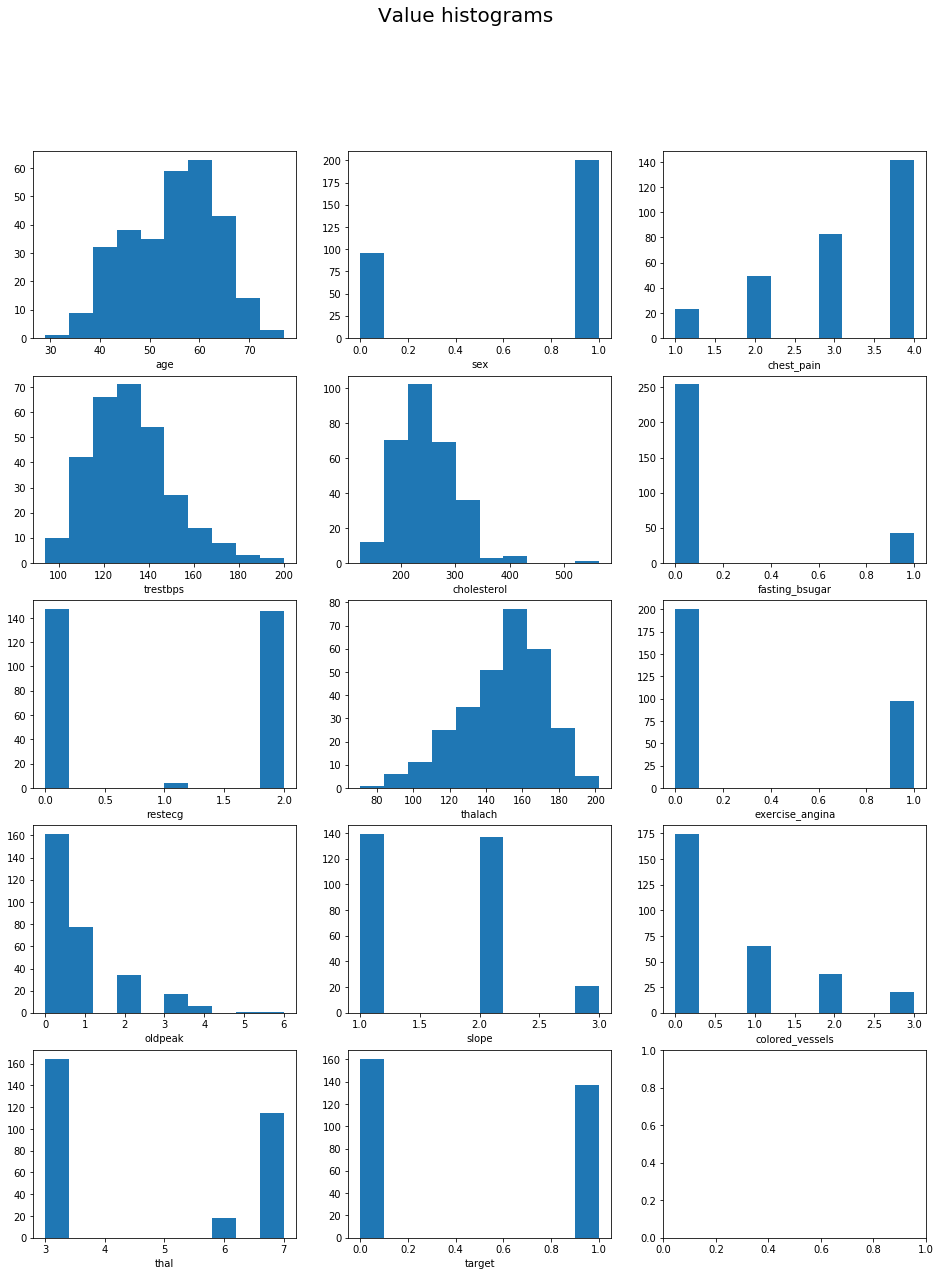

In [6]:
fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(16,20))
fig.suptitle('Value histograms', fontsize=20)
ax = ax.flatten()

for i, col in enumerate(list(data)):
    ax[i].hist(x=data[col].astype(int))
    ax[i].set_xlabel(col) 

There are several categorical attributes: sex, fasting_bsugar, chest_pain, exercise_angina, restecg, colored_vessels, thal and slope. These have to be numerically encoded. We could consider one-hot encoding for attributes with more than 2 categories that do not have a natural ordering (such as chest_pain, slope, thal). However, I don't think that would have a large effect on the performance of the model.

We'll need a function to train our models and print important metrics.

In [7]:
def fit_and_print_performance(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    
    pred_test = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    print('Accuracy on test: {0:.4f}'.format(accuracy), '\nMAE train: {0:.4f}'.format(mae_train),
          '\tMAE test: {0:.4f}'.format(mae_test))

We should use the same data split to compare models because different splits could lead to different performance.

In [8]:
x = data.loc[:, :'thal'].values
y = data.loc[:, 'target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y)

### Decision tree based models

In [9]:
tree = DecisionTreeClassifier()
fit_and_print_performance(tree, x_train, x_test, y_train, y_test)

Accuracy on test: 0.6667 
MAE train: 0.0000 	MAE test: 0.3333


Let's visualise the tree. For the following code to work, we need `graphviz` installed in the environment.

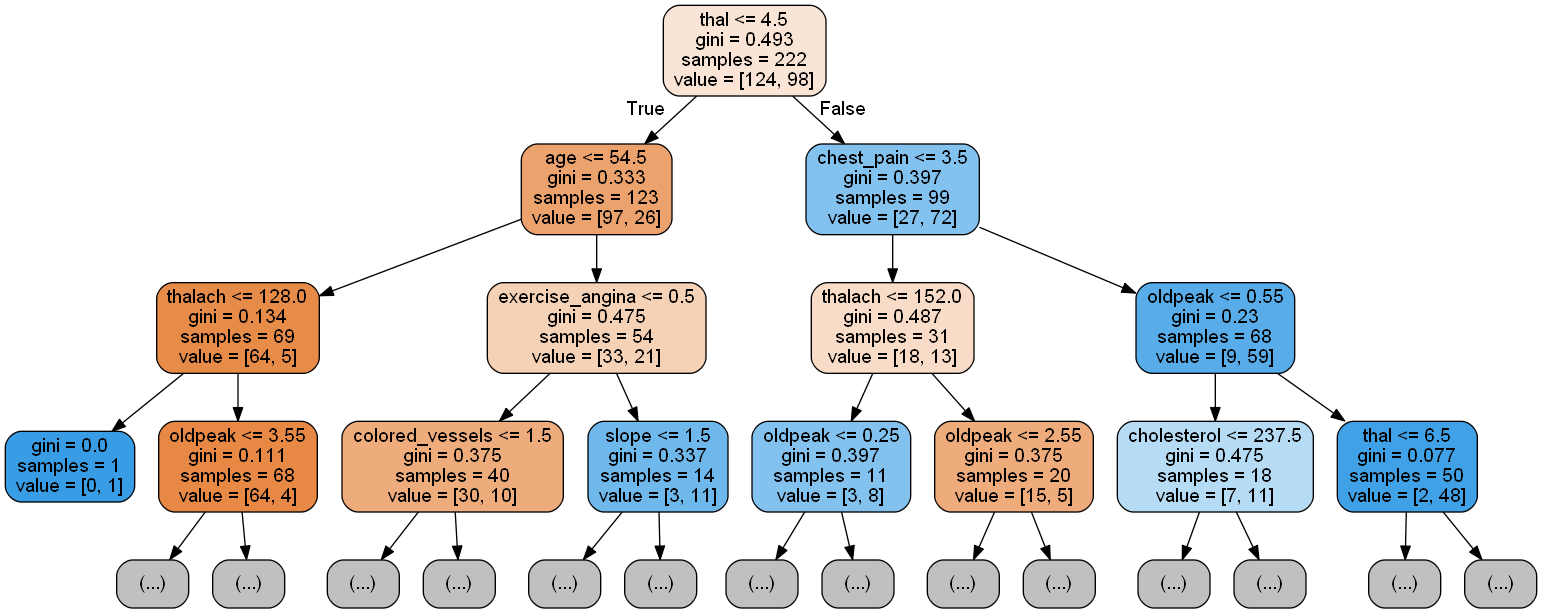

In [10]:
from sklearn.tree import export_graphviz
from IPython.display import Image, display


with open('tree.dot', 'w+') as dotfile:
    export_graphviz(tree, max_depth=3, out_file=dotfile, rounded=True, filled=True, feature_names=list(data)[:-1])

# Convert file to png
!dot -Tpng tree.dot -o tree.png
# Display in notebook
display(Image("tree.png"))

Visualising decision trees trained on a dataset is a good way to see which attributes are the most important. The attributes found at the root of the tree are the ones with the largest predictive value. Decision trees are quite stochastic, so a more reliable way to understand the importance of features is to look at ensembles.

Let's try a few ensemble methods and visualise the feature importances found by them. To do that, we'll need a function.

In [11]:
def plot_feature_importance(feat_names, importances, modelname):
    # Sort attributes in order of importance
    names_imps = list(zip(feat_names, importances))
    names_imps = sorted(names_imps, key=lambda pair: pair[1])
    names, imps = zip(*names_imps)
    
    # Plot a horizontal bar chart
    fig, ax = plt.subplots()
    indexes = np.arange(len(names_imps)) 
    ax.barh(indexes, width=imps, tick_label=names, height=0.8)
    ax.set_xlabel('Relative importance')
    ax.set_title(modelname + ' feature importance', fontsize=15)

Accuracy on test: 0.7867 
MAE train: 0.0000 	MAE test: 0.2133


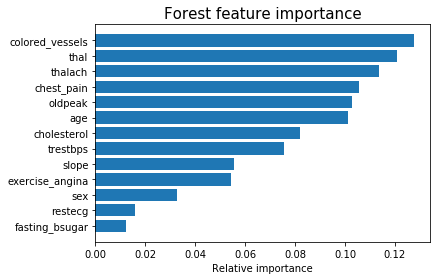

In [12]:
forest = RandomForestClassifier(n_estimators=50)
fit_and_print_performance(forest, x_train, x_test, y_train, y_test)
plot_feature_importance(list(data), forest.feature_importances_, 'Forest')

Accuracy on test: 0.8000 
MAE train: 0.0000 	MAE test: 0.2000


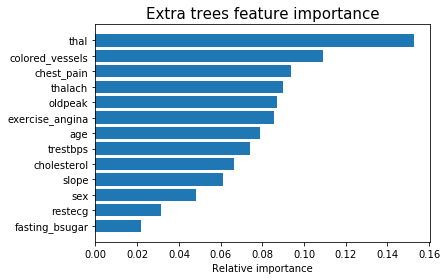

In [13]:
extra = ExtraTreesClassifier(n_estimators=50)
fit_and_print_performance(extra, x_train, x_test, y_train, y_test)
plot_feature_importance(list(data), extra.feature_importances_, 'Extra trees')

Accuracy on test: 0.7867 
MAE train: 0.0225 	MAE test: 0.2133


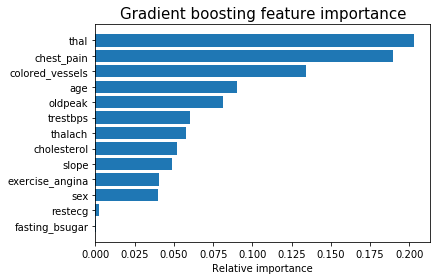

In [14]:
gdboost = GradientBoostingClassifier(n_estimators=50)
fit_and_print_performance(gdboost, x_train, x_test, y_train, y_test)
plot_feature_importance(list(data), gdboost.feature_importances_, 'Gradient boosting')

Random forest have a better performance than a single decision tree. The reason for that is because it averages out predictions over several trees. Because each tree is trained on a different subset of the data, it makes mistakes on different instances.

Extra trees are faster to train than random forests because the threshold at which instances are split at each node is chosen randomly. This also makes extra trees more resilient and harder to overfit. However, in our case we have a very small dataset so speed is not an issue.

Gradient boosting is the most interesting ensemble out of these because each additional decision tree is trained on the residual errors of its predecessor. It doesn't have a better performance than random forest on this dataset. However, it's the only approach that does not overfit as badly! All of decision tree, random forest, and extra trees have 0 MAE over the training dataset.

###### Feature importance
The importances vary across the three ensemble methods and across different runs but we can say that, generally, the most important features are: colored_vessels, thal, chest_pain, thalach, age, cholesterol, and oldpeak.

Knowing this is important because it also allows us to understand the quality of other datasets. If there are missing values for features that don't have predictive value, it doesn't matter as we can drop the attribute without a worry.

### Logistic regression, SVM, Naive Bayes

In [15]:
logreg = LogisticRegression(solver='liblinear') # regularisation is l2 by default
fit_and_print_performance(logreg, x_train, x_test, y_train, y_test)

Accuracy on test: 0.8400 
MAE train: 0.1486 	MAE test: 0.1600


In [16]:
fit_and_print_performance(SVC(kernel='linear'), x_train, x_test, y_train, y_test)

Accuracy on test: 0.8533 
MAE train: 0.1396 	MAE test: 0.1467


In [17]:
fit_and_print_performance(SVC(kernel='rbf', gamma=0.0001), x_train, x_test, y_train, y_test)

Accuracy on test: 0.6933 
MAE train: 0.2928 	MAE test: 0.3067


In [18]:
fit_and_print_performance(GaussianNB(), x_train, x_test, y_train, y_test)

Accuracy on test: 0.8533 
MAE train: 0.1577 	MAE test: 0.1467


In [19]:
fit_and_print_performance(BernoulliNB(), x_train, x_test, y_train, y_test)

Accuracy on test: 0.8133 
MAE train: 0.2027 	MAE test: 0.1867


It looks like logistic regression has the higher accuracy than polynomial SVM (with rbf kernel), I suspect that the dataset is linearly separable.

Gaussian Naive Bayes seems to perform really well!

The next step would be to include more data. There are 4 csv files with 923 samples in total. However, the files are of varied quality, with some of them having more missing values. A solution to this is to train on fewer attributes (ignoring ones with lots of missing values).

# More data

Append all csv files into one `DataFrame`.

In [20]:
csvfiles = ['processed_hungarian_data.csv', 'processed_switzerland_data.csv', 'processed_va_data.csv']
alldata = data

for file in csvfiles:
    df = pd.read_csv('data/' + file)
    df = preprocess(df)
    alldata = alldata.append(df)
    

print(alldata.info())

<class 'pandas.core.frame.DataFrame'>
Index: 914 entries, 0 to 199
Data columns (total 14 columns):
age                914 non-null int64
sex                914 non-null bool
chest_pain         914 non-null int64
trestbps           855 non-null float64
cholesterol        884 non-null float64
fasting_bsugar     824 non-null float64
restecg            912 non-null float64
thalach            859 non-null float64
exercise_angina    859 non-null float64
oldpeak            852 non-null float64
slope              605 non-null float64
colored_vessels    307 non-null float64
thal               430 non-null float64
target             914 non-null int64
dtypes: bool(1), float64(10), int64(3)
memory usage: 100.9+ KB
None


Well this is disappointing, some of the attributes we found to be the most important have the most missing values (colored_vessels and thal). We now have two options: we either decide not to use the other three files, or we retrain our models without the colored_vessels attribute on the few instances with values for thal. This would add a third more training instances, so it is a relevant amount.

I will go with the second choice because I think we could still recover important data.

In [21]:
alldata = alldata.dropna(subset=['thal'])
alldata = alldata.drop(['fasting_bsugar', 'slope', 'colored_vessels'], axis=1)
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, 0 to 197
Data columns (total 11 columns):
age                430 non-null int64
sex                430 non-null bool
chest_pain         430 non-null int64
trestbps           426 non-null float64
cholesterol        428 non-null float64
restecg            430 non-null float64
thalach            428 non-null float64
exercise_angina    428 non-null float64
oldpeak            423 non-null float64
thal               430 non-null float64
target             430 non-null int64
dtypes: bool(1), float64(7), int64(3)
memory usage: 37.4+ KB


We should fill the remaining missing values with the averages in each column. We can get the means from the statistical description of the dataset from the beginning of this notebook.

In [22]:
alldata.trestbps = alldata.trestbps.fillna(value=131.71, axis=0)
alldata.cholesterol = alldata.cholesterol.fillna(value=246.93, axis=0)
alldata.thalach = alldata.thalach.fillna(value=149.70, axis=0)
alldata.exercise_angina = alldata.exercise_angina.fillna(value=0, axis=0)
alldata.oldpeak = alldata.oldpeak.fillna(value=0, axis=0)
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, 0 to 197
Data columns (total 11 columns):
age                430 non-null int64
sex                430 non-null bool
chest_pain         430 non-null int64
trestbps           430 non-null float64
cholesterol        430 non-null float64
restecg            430 non-null float64
thalach            430 non-null float64
exercise_angina    430 non-null float64
oldpeak            430 non-null float64
thal               430 non-null float64
target             430 non-null int64
dtypes: bool(1), float64(7), int64(3)
memory usage: 37.4+ KB


### Fit models again

In [23]:
all_x = alldata.loc[:, :'thal'].values
all_y = alldata.loc[:, 'target'].values
all_x_train, all_x_test, all_y_train, all_y_test = train_test_split(all_x, all_y)

In [24]:
fit_and_print_performance(LogisticRegression(solver='liblinear'), all_x_train, all_x_test, all_y_train, all_y_test)

Accuracy on test: 0.8241 
MAE train: 0.1615 	MAE test: 0.1759


Logistic regression is not performing much different on the larger dataset than before, even though there is more data, it is of lower quality. 

Accuracy on test: 0.8056 
MAE train: 0.0280 	MAE test: 0.1944


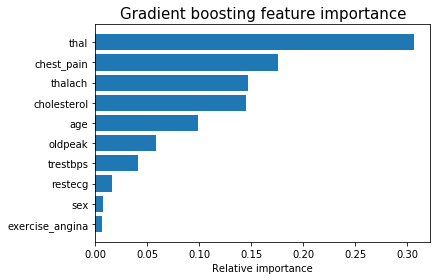

In [25]:
gdboost = GradientBoostingClassifier()
fit_and_print_performance(gdboost, all_x_train, all_x_test, all_y_train, all_y_test)
plot_feature_importance(list(alldata), gdboost.feature_importances_, 'Gradient boosting')

Somehow, cholesterol gained a lot of importance after removing the columns 'fasting_bsugar', 'slope', 'colored_vessels'.

In [26]:
fit_and_print_performance(GaussianNB(), all_x_train, all_x_test, all_y_train, all_y_test)

Accuracy on test: 0.8333 
MAE train: 0.1584 	MAE test: 0.1667


It looks like, given more data, all models performed quite a bit better. I would choose `GaussianNB` to classify this dataset, as it is simple and fits the data well: the training and testing MAE are similar so it's not overfitting.

At this point, we should fine-tune the model and spend time on selecting good hyper-parameters. Fortunately, the scikit-learn `GaussianNB` implementation does not have any hyper-parameters which require tuning. But if I were to tune `GradientBoostingClassifier`, I would use grid search and cross validation, as you can see in the following code cell.

I have run each line of the parameter grid individually, to find the best value of each parameter, and then combined them together.

In [27]:
param_grid = [
#     {'loss' : ['deviance', 'exponential']}, # best: deviance (the default)
#     {'max_depth': range(1, 9)}, # best: 2
#     {'max_features': np.linspace(0.6, 0.9, 15)}, # best: 0.68
#     {'min_impurity_decrease': np.linspace(0.001, 1, 12)}, # best: 0.63
#     {'min_samples_split': range(2, 9)}, # best: 3
#     {'min_samples_leaf': range(1, 8)}, # best: 1 (the default)
#     {'n_estimators': range(60, 120, 10)}, # best: 80

    # Combining the best values found. Compare with defaults
    {'max_depth': [2, 3], 'max_features': [0.68, None], 'min_impurity_decrease': [0.63, 0], 'min_samples_split': [3, 2], 
     'n_estimators': [80, 100]}
]

gdboost = GradientBoostingClassifier()
grid_search = GridSearchCV(gdboost, param_grid, cv=5)
grid_search.fit(all_x, all_y)

print(grid_search.best_params_)
print('Accuracy: ' + str(grid_search.best_score_))

{'max_depth': 2, 'max_features': 0.68, 'min_impurity_decrease': 0, 'min_samples_split': 3, 'n_estimators': 100}
Accuracy: 0.8186046511627907


In [33]:
gdboost = GradientBoostingClassifier(max_depth=2, max_features=0.68, min_impurity_decrease=0.63, min_samples_split=3,
                                     n_estimators=80)
fit_and_print_performance(gdboost, all_x_train, all_x_test, all_y_train, all_y_test)

Accuracy on test: 0.7870 
MAE train: 0.0932 	MAE test: 0.2130


Sometimes, the defaults are always best! Tuning the parameters has lead to a more regularised model, because the training MAE is larger compared to the default model.